### Import Dataset

In [1]:
import mung
from pycocotools.coco import COCO
from omrdatasettools import Downloader, OmrDataset
import os

import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
#from torchvision.transforms import ToTensor
from torchvision.io import read_image
import pandas as pd
from PIL import Image
import json

In [2]:
downloader = Downloader()
downloader.download_and_extract_dataset(dataset=OmrDataset.MuscimaPlusPlus_V2, 
                                        destination_directory='muscima')
downloader.download_and_extract_dataset(dataset=OmrDataset.MuscimaPlusPlus_MeasureAnnotations,
                                        destination_directory="muscima/v2.0/data/measure")


Extracting MuscimaPlusPlus_V2 dataset...
Deleting temporary directory c:\Repositories\music\MuscimaPpImages
Extracting MuscimaPlusPlus_MeasureAnnotations dataset...


In [3]:
imagepath = 'muscima/v2.0/data/images'
annotationpath = 'muscima/v2.0/data/measure/json'

In [4]:
anns = list(sorted(os.listdir(annotationpath)))

anns[0]


'CVC-MUSCIMA_W-01_N-10_D-ideal.json'

In [5]:
with open(os.path.join(annotationpath, anns[0])) as f:
  sample_ann = json.loads(f.read())
  print(sample_ann.keys())
  #xmin = sample_ann['system_measures'][0]['bottom']
  #print(xmin)

dict_keys(['width', 'height', 'system_measures', 'stave_measures', 'staves'])


In [6]:
class MuscimaMeasures(Dataset):
  def __init__(self, imagepath, annotationpath, transforms=None, target_transforms=None):
    self.imgpath = imagepath
    self.annpath = annotationpath

    self.imgs = list(sorted(os.listdir(imagepath)))
    self.anns = list(sorted(os.listdir(annotationpath)))

    self.transforms = transforms
    self.target_transforms = target_transforms

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    image = Image.open(os.path.join(self.imgpath, self.imgs[idx]))
    target = {}
    height = 0
    width = 0
    labels = []
    boxes = []
    iscrowd = []
    image_id = torch.tensor([idx])
    with open(os.path.join(self.annpath, self.anns[idx])) as f:
      annotations = json.loads(f.read())
      width = annotations['width']
      height = annotations['height']

      objs = annotations['system_measures']
      for i in range(len(objs)):
        xbox = np.asarray([objs[i]['left'], objs[i]['right']])
        ybox = np.asarray([objs[i]['top'], objs[i]['bottom']])
        
        xmin = np.min(xbox)
        xmax = np.max(xbox)
        ymin = np.min(ybox)
        ymax = np.max(ybox)
        boxes.append([xmin, ymin, xmax, ymax])
      labels = torch.ones(len(annotations['system_measures']), dtype=torch.int64)
      iscrowd = torch.zeros(len(annotations['system_measures']), dtype=torch.int64)
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd

    

    if self.transforms is not None:
      image, target = self.transforms(image, target)
    #  image = self.transforms(image)
    if self.target_transforms is not None:
      target['boxes'] = self.transforms(target['boxes'])

    image = torch.from_numpy(np.expand_dims(np.array(image)*1, 0)).type(torch.FloatTensor)

    return image, target

In [106]:
from transforms import Compose, RandomHorizontalFlip

transforms = Compose([RandomHorizontalFlip(p=1.0)])

dataset = MuscimaMeasures(imagepath, annotationpath, transforms)


In [107]:
sample_im, sample_ann = dataset[0]

sample_boxes = sample_ann['boxes']
sample_im = (255*sample_im).type(torch.ByteTensor)

sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes, width=5)
Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

AttributeError: module 'torchvision.transforms.functional' has no attribute 'get_dimensions'

In [7]:
import visionutils
from visionutils.engine import train_one_epoch, evaluate
from visionutils import utils
from visionutils import transforms as T

In [8]:
from torchvision.transforms import ToTensor


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [24]:
transforms = T.Compose([ToTensor()])

dataset = MuscimaMeasures(imagepath, annotationpath)
sample_im, sample_ann = dataset[0]

In [70]:
dataset = MuscimaMeasures(imagepath, annotationpath, None)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

In [56]:
sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']

sample_im = (255*sample_im).type(torch.ByteTensor)

In [27]:
print(torch.max(sample_im))

sample_boxes

tensor(1, dtype=torch.uint8)


tensor([[ 215., 1205.,  865., 1560.],
        [ 216.,  265.,  678.,  619.],
        [ 693.,  265.,  963.,  619.],
        [ 978.,  265., 1320.,  619.],
        [1334.,  265., 1727.,  619.],
        [1736.,  265., 2193.,  619.],
        [2203.,  265., 2835.,  619.],
        [2846.,  265., 3344.,  619.],
        [ 215.,  734.,  885., 1089.],
        [ 900.,  734., 1564., 1089.],
        [1575.,  734., 2082., 1089.],
        [2094.,  734., 2493., 1089.],
        [2505.,  734., 3015., 1089.],
        [3025.,  734., 3343., 1089.]])

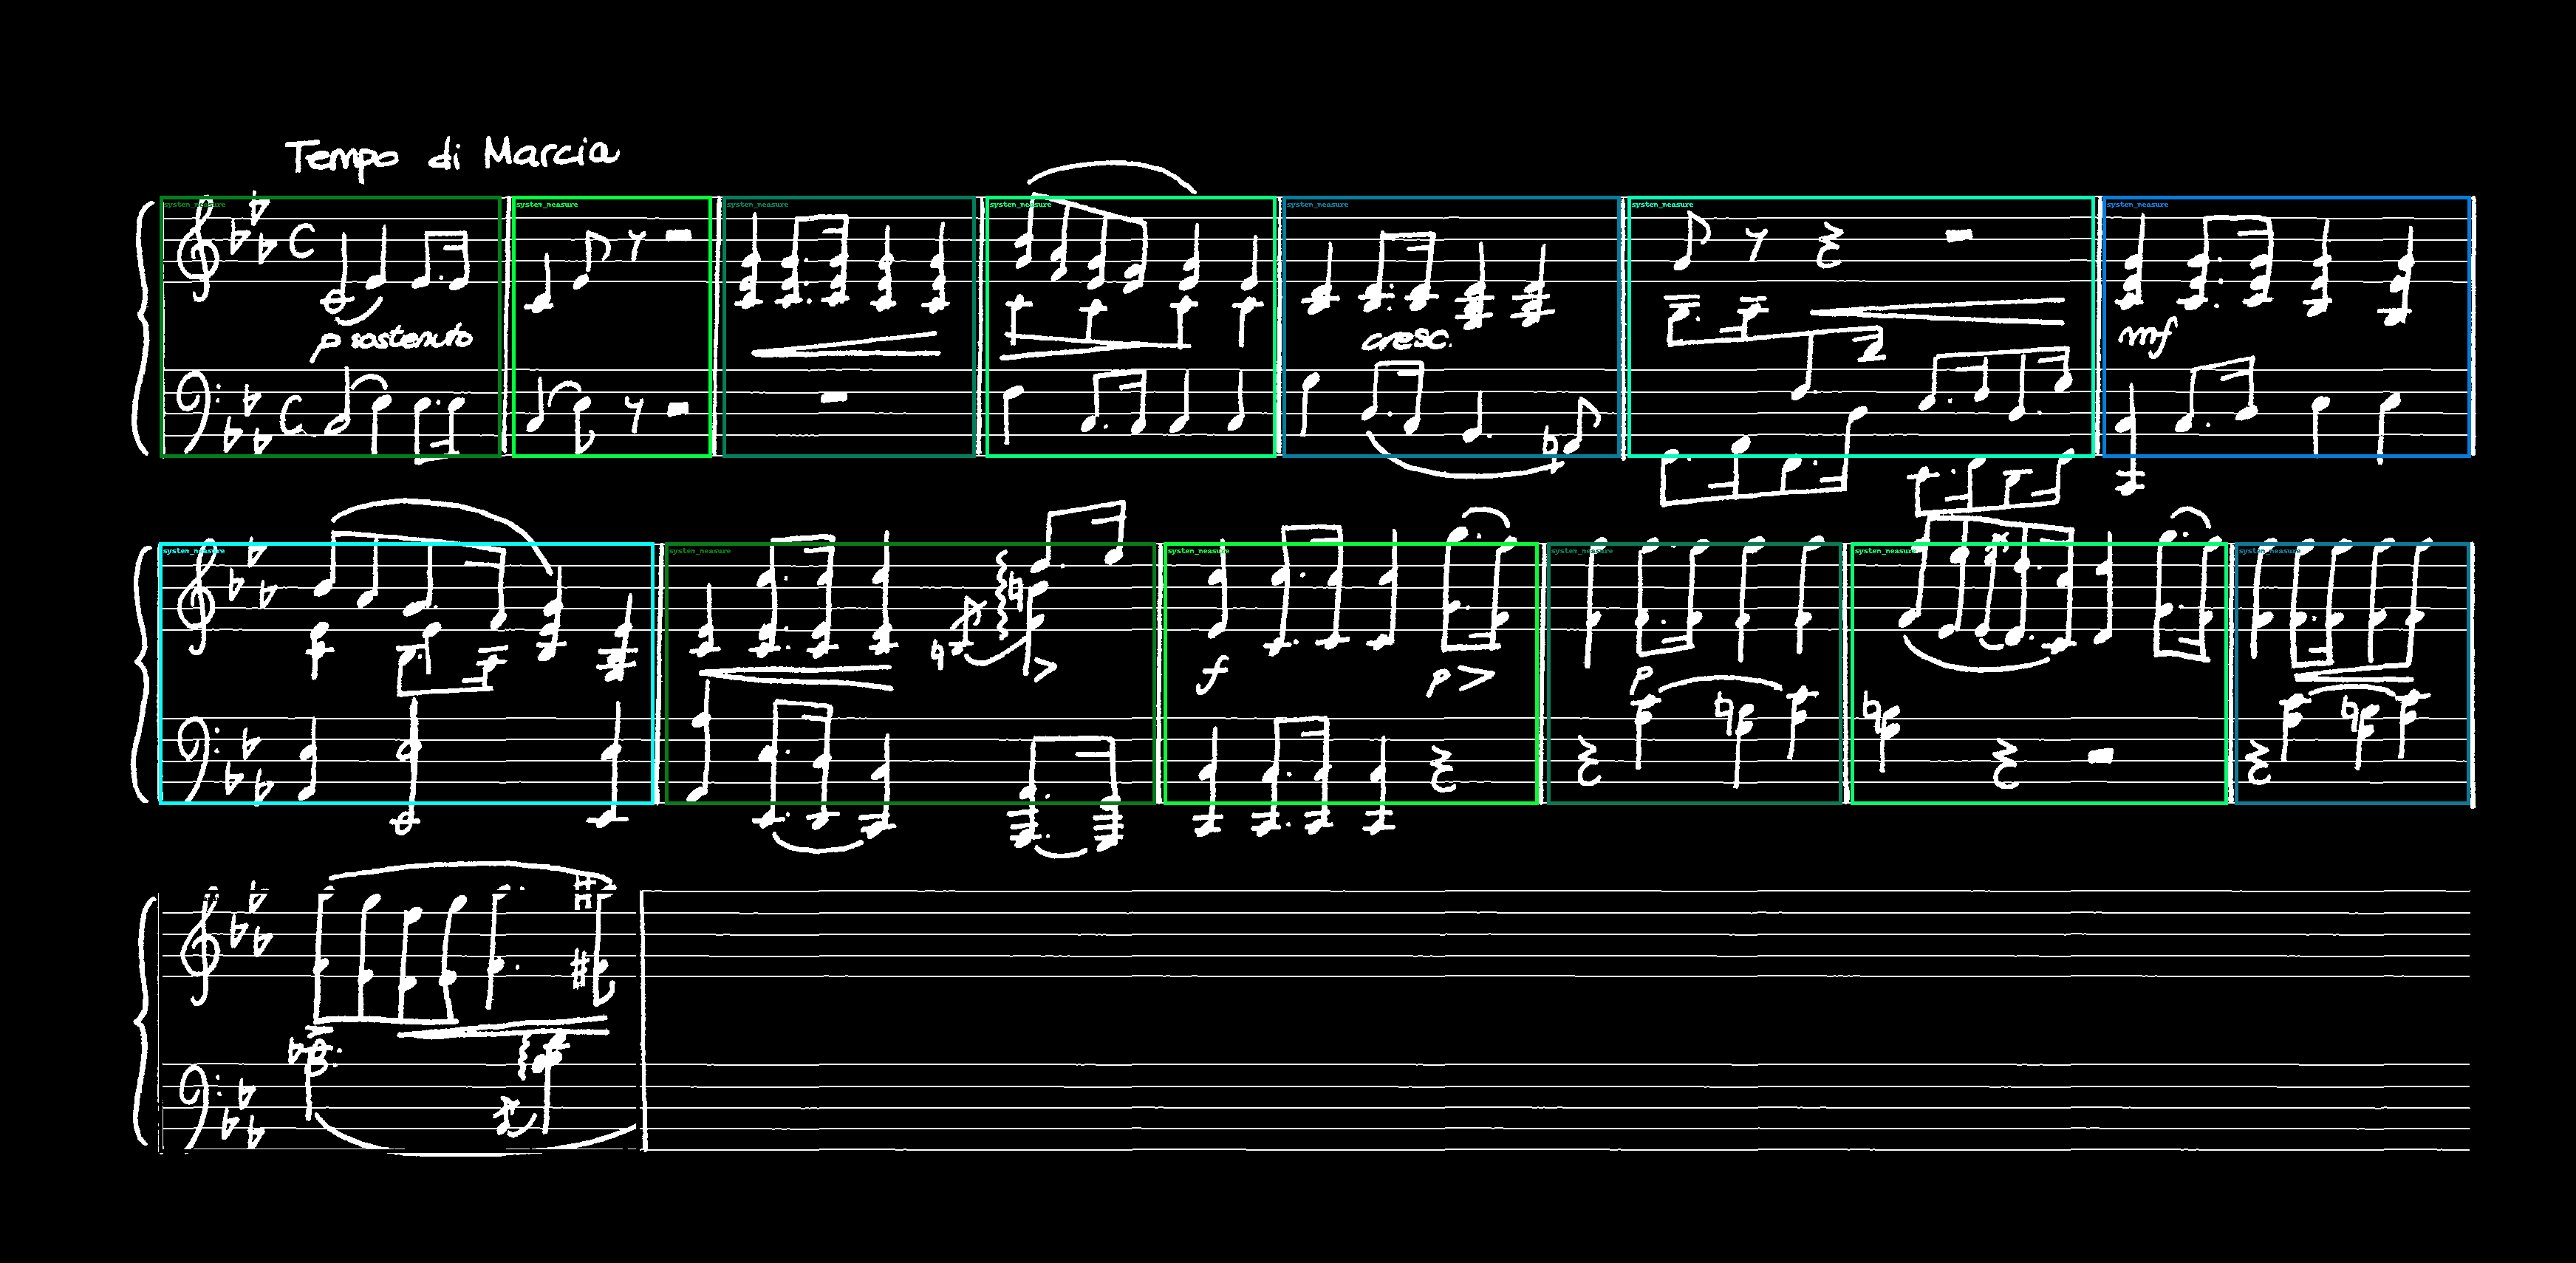

In [76]:
from torchvision.utils import draw_bounding_boxes

labels = ['system_measure' for i in range(sample_boxes.shape[0])]

sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes, labels, width=5)

sample_im_with_bounding_boxes.shape
Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

In [73]:
labels

{0: 'system_measure',
 1: 'system_measure',
 2: 'system_measure',
 3: 'system_measure',
 4: 'system_measure',
 5: 'system_measure',
 6: 'system_measure',
 7: 'system_measure',
 8: 'system_measure',
 9: 'system_measure',
 10: 'system_measure',
 11: 'system_measure',
 12: 'system_measure',
 13: 'system_measure'}

### Import Model

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Pretrained model

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [9]:
def get_faster_rcnn_with_n_classes(n: int):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n)

  return model

In [10]:
images, targets = next(iter(dataloader))
images[0]


NameError: name 'dataloader' is not defined

In [72]:
# Test

images, targets = next(iter(dataloader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

In [11]:
#dataset = MuscimaMeasures(imagepath, annotationpath, get_transform(train=True))
#dataset_test = MuscimaMeasures(imagepath, annotationpath, get_transform(train=False))
dataset = MuscimaMeasures(imagepath, annotationpath, None)
dataset_test = MuscimaMeasures(imagepath, annotationpath, None)

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

100
40


In [12]:
model = get_faster_rcnn_with_n_classes(2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# learning rate 10x reduction every three epocs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [13]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

run_training_and_validation = True

if run_training_and_validation:
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/50]  eta: 0:02:07  lr: 0.000107  loss: 2.3248 (2.3248)  loss_classifier: 0.9076 (0.9076)  loss_box_reg: 0.2966 (0.2966)  loss_objectness: 0.9761 (0.9761)  loss_rpn_box_reg: 0.1444 (0.1444)  time: 2.5560  data: 0.0850  max mem: 2321
Epoch: [0]  [10/50]  eta: 0:00:34  lr: 0.001126  loss: 1.9421 (2.0576)  loss_classifier: 0.6126 (0.6338)  loss_box_reg: 0.4098 (0.5066)  loss_objectness: 0.3821 (0.6947)  loss_rpn_box_reg: 0.2230 (0.2225)  time: 0.8740  data: 0.0729  max mem: 2873
Epoch: [0]  [20/50]  eta: 0:00:24  lr: 0.002146  loss: 1.4539 (1.7243)  loss_classifier: 0.4385 (0.5478)  loss_box_reg: 0.5177 (0.5383)  loss_objectness: 0.1905 (0.4481)  loss_rpn_box_reg: 0.1593 (0.1901)  time: 0.7142  data: 0.0715  max mem: 2875
Epoch: [0]  [30/50]  eta: 0:00:15  lr: 0.003165  loss: 1.2421 (1.5326)  loss_classifier: 0.4218 (0.4968)  loss_box_reg: 0.5228 (0.5374)  loss_objectness: 0.1175 (0.3326)  loss_rpn_box_reg: 0.1261 (0.1658)  time: 0.7105  data: 0.0690  max mem: 2875
Loss is 

SystemExit: 1

C:\Users\explo\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3259: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
%tb

SystemExit: 1

### Visualize Results

In [19]:
def visualize_bboxes(image, target, labels=None):
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    boxes_sliced = boxes[0:torch.max(torch.nonzero(scores>0.5)),:]

    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, labels, colors='red', width=3)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


In [25]:
GPU = torch.device('cuda')
#index = torch.tensor([0, 1]).to(GPU)
boxes = detections[0]['boxes']
scores = detections[0]['scores']

boxes_sliced = boxes[0:torch.max(torch.nonzero(scores>0)),:]

print(torch.nonzero(scores>0.5))
print(boxes_sliced)
#print(torch.index_select(boxes, 0, index).shape)

tensor([[ 0],
        [ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11]], device='cuda:0')
tensor([[1137.8326,  728.8386, 1804.5106, 1098.3279],
        [1820.1869,  748.4312, 2351.4712, 1089.9805],
        [ 201.7419,  729.0411, 1109.0779, 1087.7693],
        [2368.6687,  751.8054, 2864.8303, 1095.0747],
        [1450.4796,  273.5126, 2057.2065,  628.0532],
        [ 901.4367,  273.2231, 1474.3838,  623.2827],
        [ 193.4541,  285.7856,  912.3358,  634.7968],
        [2873.1331,  728.1454, 3330.7993, 1096.7351],
        [2064.1382,  268.8630, 2551.6245,  619.2515],
        [2563.6138,  263.2093, 3015.8440,  618.2141],
        [3024.8547,  283.3896, 3435.2983,  627.1821],
        [ 527.7817,  269.1056,  886.8527,  623.2803],
        [ 237.8723,  268.9313,  563.8568,  391.4548],
        [2107.5356,  284.9348, 2919.0620,  608.6282],
        [ 214.8957,  321.6597, 1050.5110, 1103.7886],
    

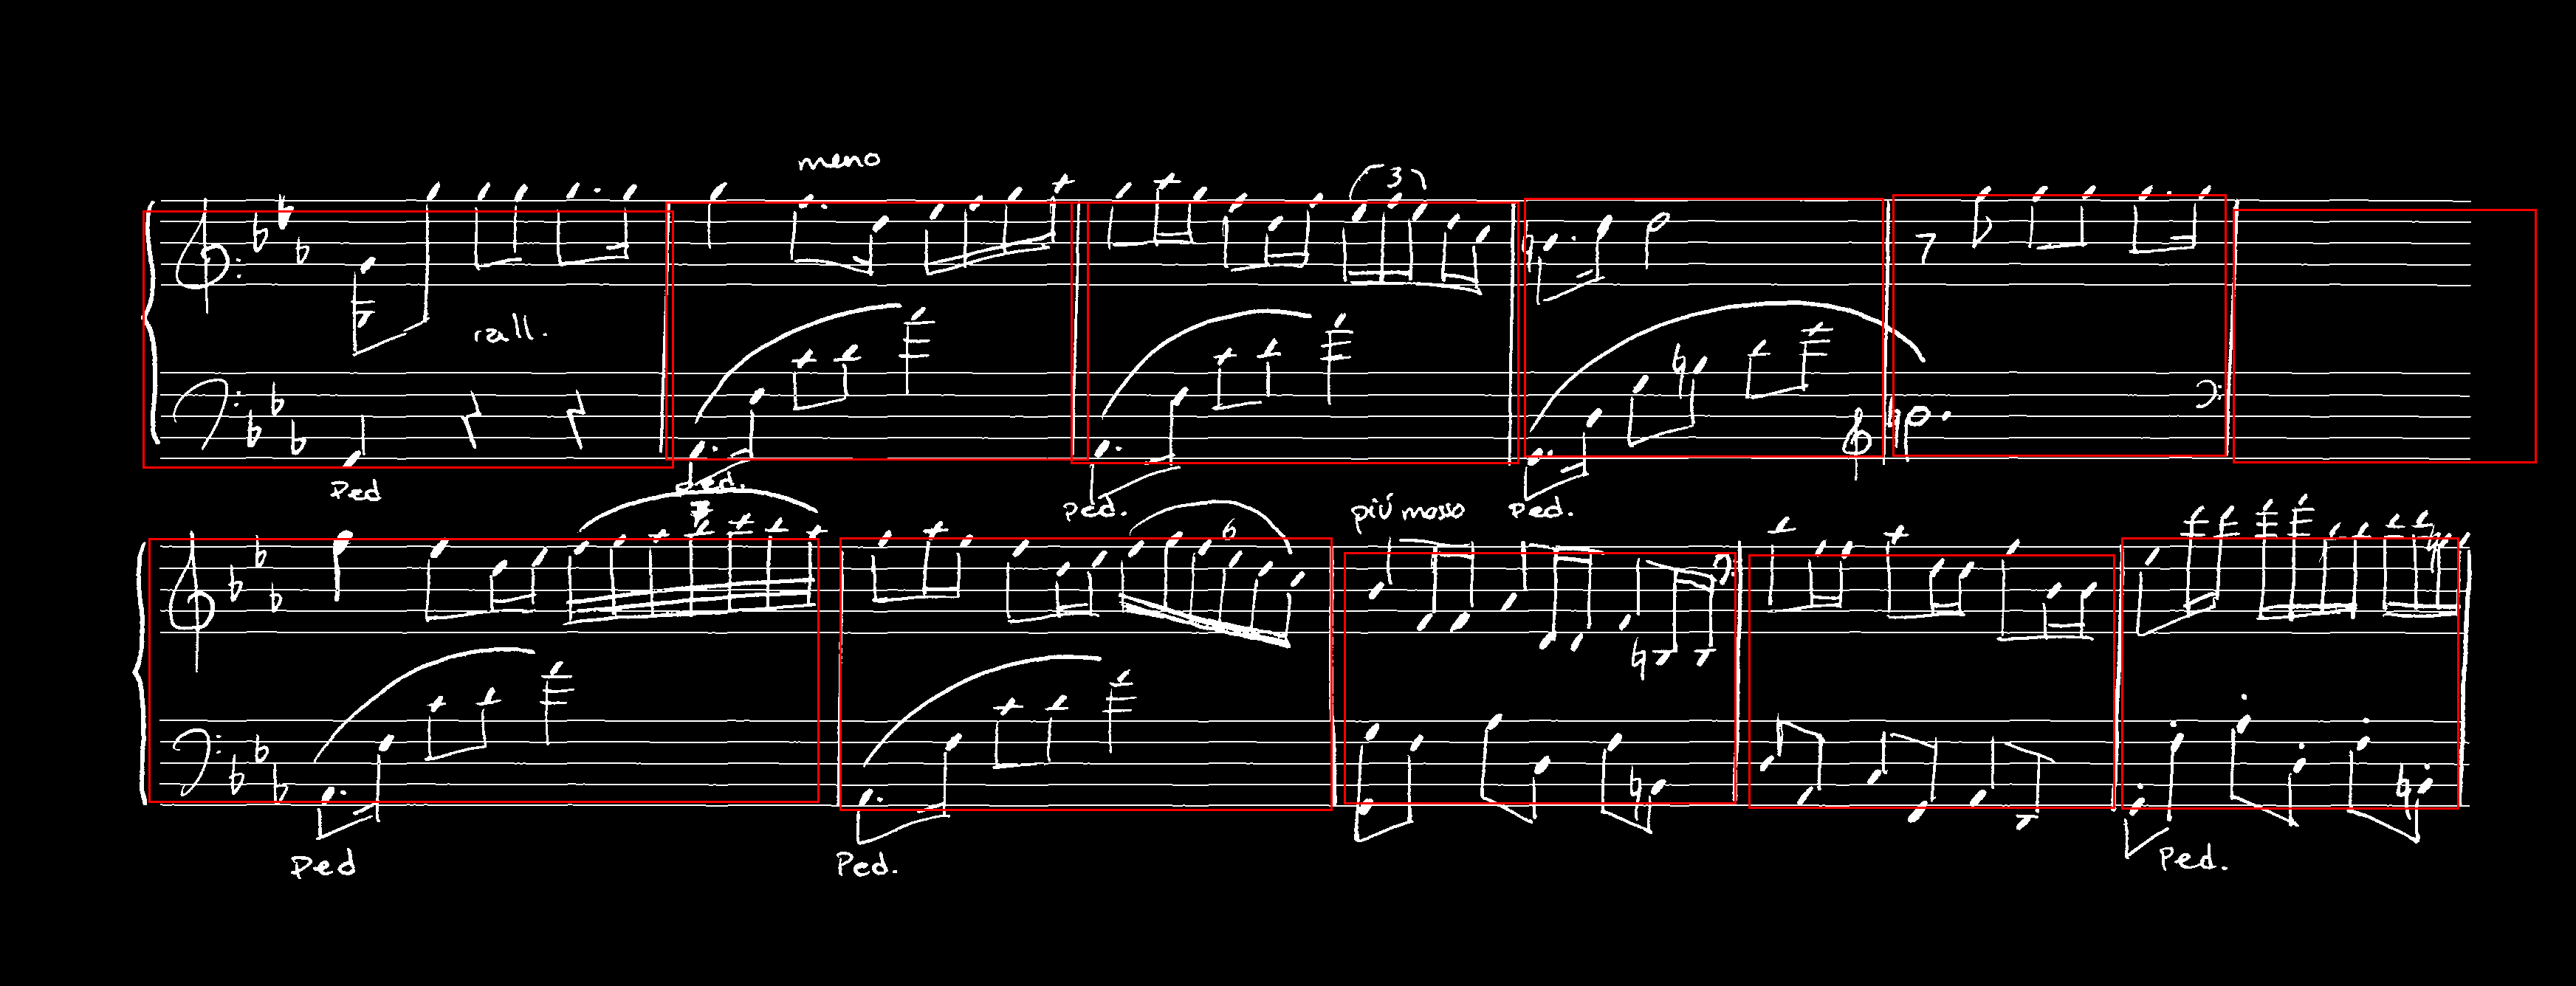

In [26]:
model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
image, target = next(iter(data_loader_test))
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)

visualize_bboxes(image[0], detections[0])

In [33]:
num_images = 5
images_with_bboxes = []
for i in range(num_images):
  image, target = next(iter(data_loader_test))
  image = list(img.to(torch.device('cuda')) for img in image)
  detections = model(image)
  images_with_bboxes.append(visualize_bboxes(image[0], detections[0]))


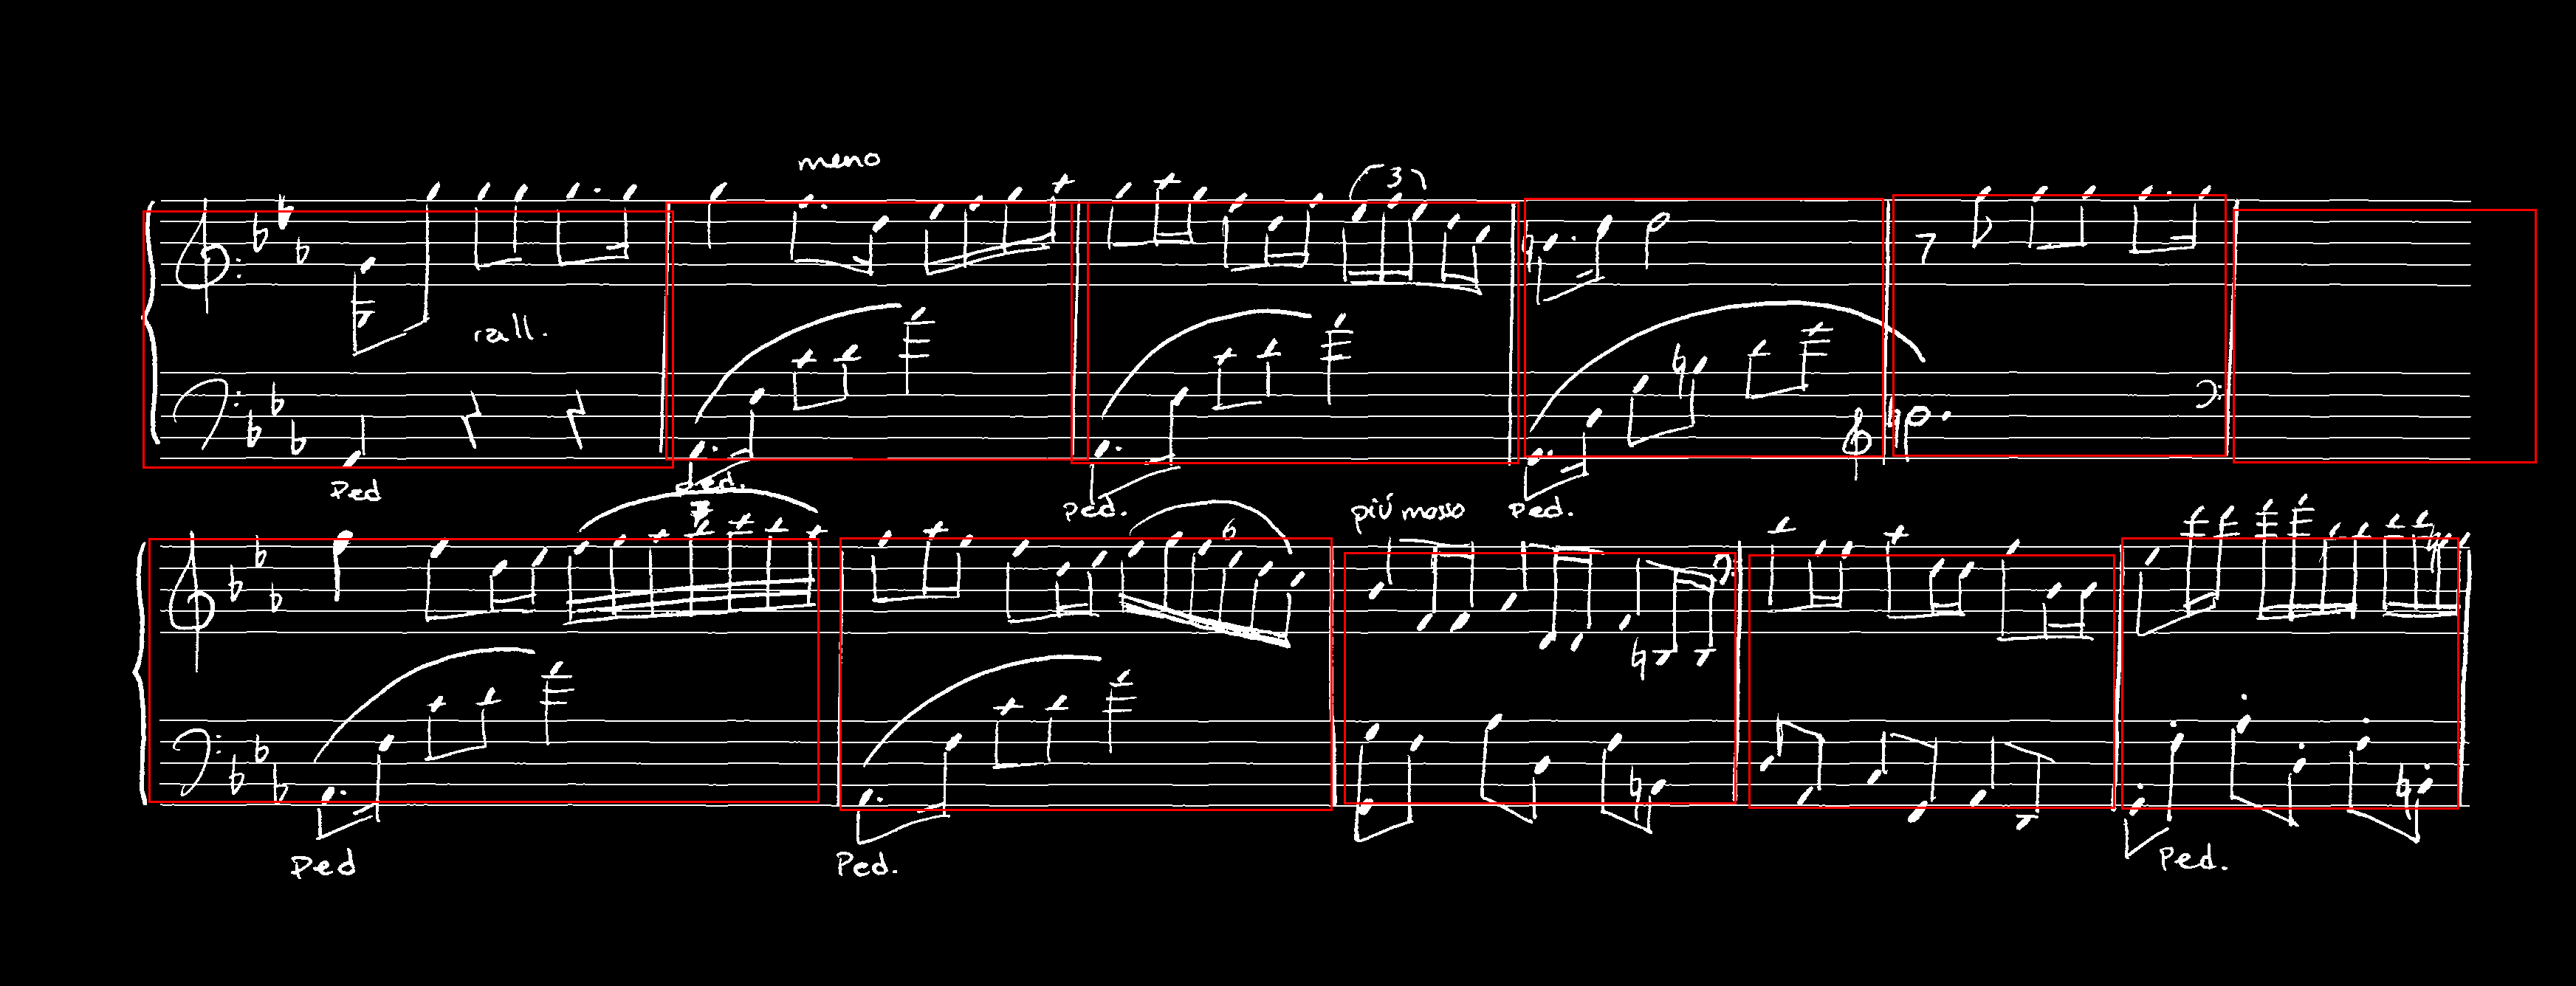

In [37]:
images_with_bboxes[1]
images_with_bboxes[3]

### Save Model

In [ ]:
# Model state_dict
print("Model's state dict:")
for param_tensor in model.state_dict():
  print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print()

# Optimizer state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
  print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
# Example only save parameters
SAVE_PARAMETERS = "state_dict_model.pt"

torch.save(model.state_dict(), SAVE_PARAMETERS)

model2 = get_faster_rcnn_with_n_classes(2)
model2.load_state_dict(torch.load(SAVE_PARAMETERS))

model2.eval()

In [ ]:
# Example save everything
SAVE_ENTIRE_MODEL = "entire_model.pt"

torch.save(model, SAVE_ENTIRE_MODEL)

model3 = torch.load(SAVE_ENTIRE_MODEL)
model3.eval()